In [251]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce
import datetime


In [252]:
L = 4 #system size
M = 0.1 #fermion mass
N=3 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [253]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2 2>           80  
      1.         |2 2 2 1>           79  
      2.         |2 2 2 0>           78  
      3.         |2 2 1 2>           77  
      4.         |2 2 1 1>           76  
      5.         |2 2 1 0>           75  
      6.         |2 2 0 2>           74  
      7.         |2 2 0 1>           73  
      8.         |2 2 0 0>           72  
      9.         |2 1 2 2>           71  
     10.         |2 1 2 1>           70  
     11.         |2 1 2 0>           69  
     12.         |2 1 1 2>           68  
     13.         |2 1 1 1>           67  
     14.         |2 1 1 0>           66  
     15.         |2 1 0 2>           65  
     16.         |2 1 0 1>           64  
     17.         |2 1 0 0>           63  
     18.         |2 0 2 2>           62  
     19.         |2 0 2 1>           61  
     20.         |2 0 2 0>           60  
     21.         |2 0 1 2>           59  
     22

In [254]:
#initialisation of the Gauss laws
LL = 3 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []


for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[3]],
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste_m[2]],
    ["z",liste_m[1]],
])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste[2]],
    ["I",liste[3]],
])

for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [255]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [256]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [257]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [258]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
a = np.zeros(2*l+1)
for i in range(2*l+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [259]:
D = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(4*l+1)
d[2*l] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(4*3+1)
for i in range(4*l+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [260]:
E = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(4*l+1)
e[2*l-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(4*3+1)
for i in range(4*l+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 1. 0. 0. 0.]


In [261]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [262]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []

interaction_p = []
interaction_m = []

phase = []
phase_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])
    quartic_term.append([[x[4],i,i,i,i]])
    quintic_term.append([[x[5],i,i,i,i,i]])
    sextic_term.append([[x[6],i,i,i,i,i,i]])


    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
        ["zzzz", quartic_term[i]],
        ["zzzzz", quintic_term[i]],
        ["zzzzzz", sextic_term[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]]  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]]           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**1*M,2])
mass_term.append([2*(-1)**0*M,3])


kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_ham[1].tocsc()@Proj[1])
interaction[2] = 0.5*(Proj[3]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[2]+Proj[2]@link_m_ham[2].tocsc()@phase_ham[2].tocsc()@phase_ham[1].tocsc()@Proj[3])
interaction[3] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_ham[3].tocsc()@phase_ham[0].tocsc()@Proj[0])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(2)]

plaquette[0] = 0.5*(Proj_0[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj_0[3]+Proj_0[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj_0[3])

plaquette[1] = -0.5*(Proj[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj[3]+Proj[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj[3])

h_plaq = 0

for i in range(2):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(LL+1):
    full_ham_matrix = (Proj_0[i]+Proj[i])@full_ham_matrix@(Proj_0[i]+Proj[i])

G=0
for i in range(LL+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [263]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-9.29176933e-01 -3.13068105e-01  2.65403537e-34]


In [264]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [265]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-4:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-0.92917693 -0.31306811  0.49289322]
(0.0685983398002344+0.007715559915248766j)|2 2 0 1>
(-0.15501264983240415-0.017434961121309826j)|2 2 0 0>
(0.2806552732388876+0.03156654494133291j)|2 1 1 1>
(-0.07495357783993485-0.00843036176049838j)|2 1 0 1>
(-0.06859833980023385-0.007715559915251159j)|2 1 0 0>
(0.2806552732388829+0.03156654494133365j)|1 1 1 2>
(-0.7709222766921926-0.08670905204323014j)|1 1 1 1>
(0.28065527323888667+0.031566544941321585j)|1 1 0 1>
(-0.06859833980023801-0.007715559915246088j)|1 0 2 2>
(-0.0749535778399278-0.00843036176051155j)|1 0 1 2>
(0.2806552732388819+0.03156654494134006j)|1 0 1 1>
(-0.15501264983240517-0.017434961121306644j)|0 0 2 2>
(0.06859833980023748+0.007715559915241753j)|0 0 1 2>



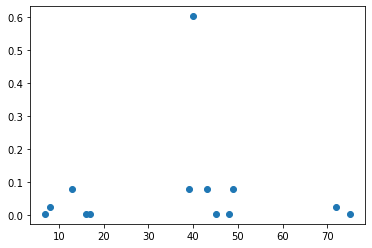

In [266]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [267]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    sigma_e = rot_sigma(0,i,j,phi,theta)@rot_sigma(3,i,j,phi,theta)
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    sigma_o = rot_sigma(1,i,j,phi,theta)@rot_sigma(2,i,j,phi,theta)
    return(sigma_o)



def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    sigma_e = sigma(0,i,j,phi) + sigma(3,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    sigma_o = sigma(1,i,j,phi) + sigma(2,i,j,phi)
    return sigma_o


In [268]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 1./np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [269]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [270]:
def R(i,theta):
    
    if i%13 == 0:
        return(ms_gate_global(theta))
     

    if i%13 == 1:
        return(rot_sigma(3,0,1,0,theta).toarray())


    if i%13 == 2:
        return(rot_sigma(3,0,2,0,theta).toarray())

    
    if i%13 == 3:
        return(rot_sigma(3,1,2,np.pi/2,theta).toarray())
    
    
    if i%13 == 4:
        return(rot_sigma(2,0,1,0,theta).toarray())


    if i%13 == 5:
        return(rot_sigma(2,0,2,0,theta).toarray())

    
    if i%13 == 6:
        return(rot_sigma(2,1,2,np.pi/2,theta).toarray())
    

    if i%13 == 7:
        return(rot_sigma(1,0,1,0,theta).toarray())


    if i%13 == 8:
        return(rot_sigma(1,0,2,0,theta).toarray())

    
    if i%13 == 9:
        return(rot_sigma(1,1,2,np.pi/2,theta).toarray())
    
    
    if i%13 == 10:
        return(rot_sigma(0,0,1,0,theta).toarray())


    if i%13 == 11:
        return(rot_sigma(0,0,2,0,theta).toarray())

    
    if i%13 == 12:
        return(rot_sigma(0,1,2,np.pi/2,theta).toarray())
    
    
def S(i):
    
    if i%13 == 0:
        return(-1j*matrix_part)
    

    if i%13 == 1:
        return(-1j*sigma(3,0,1,0).toarray())

    
    if i%13 == 2:
        return(-1j*sigma(3,0,2,0).toarray())

    
    if i%13 == 3:
        return(-1j*sigma(3,1,2,np.pi/2).toarray())


     
    if i%13 == 4:
        return(-1j*sigma(2,0,1,0).toarray())

    
    if i%13 == 5:
        return(-1j*sigma(2,0,2,0).toarray())

    
    if i%13 == 6:
        return(-1j*sigma(2,1,2,np.pi/2).toarray())


    if i%13 == 7:
        return(-1j*sigma(1,0,1,0).toarray())

    
    if i%13 == 8:
        return(-1j*sigma(1,0,2,0).toarray())

    
    if i%13 == 9:
        return(-1j*sigma(1,1,2,np.pi/2).toarray())

     
    if i%13 == 10:
        return(-1j*sigma(0,0,1,0).toarray())

    
    if i%13 == 11:
        return(-1j*sigma(0,0,2,0).toarray())

    
    if i%13 == 12:
        return(-1j*sigma(0,1,2,np.pi/2).toarray())

In [271]:
coeff = 13

In [272]:
matr = full_ham_matrix.toarray()
ones = np.ones(coeff*N)
ID = np.identity(coeff*N)
psi_0_conj = np.conj(psi_0)

In [273]:
def rhs(t,theta):
    #A = [-1j*entanglement_ham.toarray()@exp_ent(theta[0]),-1j*sigma_z.toarray()@exp_sigma_z(theta[1]),-1j*sigma_x.toarray()@exp_sigma_x(theta[2]),-1j*sigma_z.toarray()@exp_sigma_z(theta[3])]
    #B = [exp_ent(theta[0]),exp_sigma_z(theta[1]),exp_sigma_x(theta[2]),exp_sigma_z(theta[3])]
    ID = np.identity(coeff*N)
    A = []
    B = []
    print(datetime.datetime.now())
    for k in range(coeff*N):
        A.append(S(k)@R(k,theta[k]))
        B.append(R(k,theta[k]))
    CC = np.einsum("i,ljk->iljk",np.ones(coeff*N),B)

    AA = np.einsum("ijk,il->iljk",A,ID)

    BB = np.einsum("ijk,il->iljk",B,ID)

    DD = CC-BB+AA
    dd = []

    for i in range(coeff*N):
        dd.append(reduce(np.dot,DD[i]))
    DD = np.array(dd)

    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)

    BBB = reduce(np.dot,B)

    DD_d = np.einsum("kij->kji",DD.conj())
        
    X_0p5_dagger = np.einsum("m,imn->in",psi_0_conj,DD_d)
    X_0p5 = np.einsum("jnl,l->jn",DD,psi_0)

    X = np.einsum("in,jn->ij",X_0p5_dagger,X_0p5)
    
    DD_dmatr = np.einsum("imn,nl->iml",DD_d,matr)

    DD_dmatrBBB = np.einsum("iml,lk->imk",DD_dmatr,BBB)
    

    Y = np.einsum("m,imk,k->i",psi_O_conj,DD_dmatrBBB,psi_0)
    DD_dBBB  = np.einsum("imn,nk->imk",DD_d,BBB)

    XX = np.einsum("m,imk,k->i",psi_O_conj,DD_dBBB,psi_0)
    
    BBB_dagger = BBB.conj().T
    BBB_daggerDD = np.einsum("mn,ink->imk",BBB_dagger,DD)

    YY_1 = np.einsum("m,imk,k->i",psi_O_conj,BBB_daggerDD,psi_0)
    BBB_daggermatr = np.einsum("mn,nk->mk",BBB_dagger,matr)
    BBB_daggermatrBBB = np.einsum("mk,kl->ml",BBB_daggermatr,BBB)
    
    YY_2 = np.einsum("m,ml,l",psi_O_conj,BBB_daggermatrBBB,psi_0)
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.real(Y+YY)
    result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
    print(datetime.datetime.now())

    print(t)

    return result

In [274]:
stepp = 1000
t_final = 10

In [275]:
time_domain = np.linspace(0, t_final, stepp)
Y = []

In [276]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [277]:
start_point = 0.001*np.ones(coeff*N)
#for i in range(4*N):
#    start_point[i] += i/4*N
rk4(0,0.001*np.ones(coeff*N),t_final,stepp)


2022-07-21 11:06:29.097296
2022-07-21 11:06:29.798613
0
2022-07-21 11:06:29.799958
2022-07-21 11:06:30.490721
0.005
2022-07-21 11:06:30.491994
2022-07-21 11:06:31.203960
0.005
2022-07-21 11:06:31.205179
2022-07-21 11:06:31.897822
0.01
2022-07-21 11:06:31.899013
2022-07-21 11:06:32.600986
0.01
2022-07-21 11:06:32.602312
2022-07-21 11:06:33.311211
0.015
2022-07-21 11:06:33.312572
2022-07-21 11:06:34.007766
0.015
2022-07-21 11:06:34.008963
2022-07-21 11:06:34.704802
0.02
2022-07-21 11:06:34.706151
2022-07-21 11:06:35.397113
0.02
2022-07-21 11:06:35.398501
2022-07-21 11:06:36.090954
0.025
2022-07-21 11:06:36.092159
2022-07-21 11:06:36.786289
0.025
2022-07-21 11:06:36.787684
2022-07-21 11:06:37.482862
0.03
2022-07-21 11:06:37.484221
2022-07-21 11:06:38.177627
0.03
2022-07-21 11:06:38.178924
2022-07-21 11:06:38.873576
0.034999999999999996
2022-07-21 11:06:38.874851
2022-07-21 11:06:39.571444
0.034999999999999996
2022-07-21 11:06:39.572793
2022-07-21 11:06:40.273837
0.04
2022-07-21 11:06:40.2

2022-07-21 11:07:55.970967
0.3000000000000001
2022-07-21 11:07:55.972279
2022-07-21 11:07:56.727596
0.3050000000000001
2022-07-21 11:07:56.729158
2022-07-21 11:07:57.521970
0.3050000000000001
2022-07-21 11:07:57.523363
2022-07-21 11:07:58.268444
0.3100000000000001
2022-07-21 11:07:58.269726
2022-07-21 11:07:59.025733
0.3100000000000001
2022-07-21 11:07:59.026983
2022-07-21 11:07:59.779615
0.3150000000000001
2022-07-21 11:07:59.780979
2022-07-21 11:08:00.542587
0.3150000000000001
2022-07-21 11:08:00.543803
2022-07-21 11:08:01.284664
0.3200000000000001
2022-07-21 11:08:01.286072
2022-07-21 11:08:02.013659
0.3200000000000001
2022-07-21 11:08:02.015165
2022-07-21 11:08:02.745884
0.3250000000000001
2022-07-21 11:08:02.747411
2022-07-21 11:08:03.475079
0.3250000000000001
2022-07-21 11:08:03.476490
2022-07-21 11:08:04.204347
0.3300000000000001
2022-07-21 11:08:04.205625
2022-07-21 11:08:04.931030
0.3300000000000001
2022-07-21 11:08:04.932460
2022-07-21 11:08:05.664656
0.33500000000000013
2022

2022-07-21 11:09:21.495781
0.5800000000000003
2022-07-21 11:09:21.497364
2022-07-21 11:09:22.402888
0.5850000000000003
2022-07-21 11:09:22.404487
2022-07-21 11:09:23.311273
0.5850000000000003
2022-07-21 11:09:23.312617
2022-07-21 11:09:24.151276
0.5900000000000003
2022-07-21 11:09:24.152758
2022-07-21 11:09:24.984476
0.5900000000000003
2022-07-21 11:09:24.985921
2022-07-21 11:09:25.832862
0.5950000000000003
2022-07-21 11:09:25.834519
2022-07-21 11:09:26.682747
0.5950000000000003
2022-07-21 11:09:26.684327
2022-07-21 11:09:27.535048
0.6000000000000003
2022-07-21 11:09:27.536473
2022-07-21 11:09:28.381121
0.6000000000000003
2022-07-21 11:09:28.382588
2022-07-21 11:09:29.231325
0.6050000000000003
2022-07-21 11:09:29.232646
2022-07-21 11:09:30.076867
0.6050000000000003
2022-07-21 11:09:30.078359
2022-07-21 11:09:30.893790
0.6100000000000003
2022-07-21 11:09:30.895239
2022-07-21 11:09:31.782390
0.6100000000000003
2022-07-21 11:09:31.784129
2022-07-21 11:09:32.725967
0.6150000000000003
2022-

2022-07-21 11:10:56.564080
0.8650000000000005
2022-07-21 11:10:56.565663
2022-07-21 11:10:57.488435
0.8650000000000005
2022-07-21 11:10:57.489933
2022-07-21 11:10:58.407125
0.8700000000000006
2022-07-21 11:10:58.408784
2022-07-21 11:10:59.328656
0.8700000000000006
2022-07-21 11:10:59.330293
2022-07-21 11:11:00.254449
0.8750000000000006
2022-07-21 11:11:00.256007
2022-07-21 11:11:01.177965
0.8750000000000006
2022-07-21 11:11:01.179589
2022-07-21 11:11:02.170798
0.8800000000000006
2022-07-21 11:11:02.172518
2022-07-21 11:11:03.147415
0.8800000000000006
2022-07-21 11:11:03.148874
2022-07-21 11:11:04.136546
0.8850000000000006
2022-07-21 11:11:04.137908
2022-07-21 11:11:05.055424
0.8850000000000006
2022-07-21 11:11:05.056990
2022-07-21 11:11:05.936745
0.8900000000000006
2022-07-21 11:11:05.938282
2022-07-21 11:11:06.786290
0.8900000000000006
2022-07-21 11:11:06.787590
2022-07-21 11:11:07.637262
0.8950000000000006
2022-07-21 11:11:07.638732
2022-07-21 11:11:08.485018
0.8950000000000006
2022-

2022-07-21 11:12:31.457619
1.1450000000000007
2022-07-21 11:12:31.459084
2022-07-21 11:12:32.304097
1.1500000000000008
2022-07-21 11:12:32.305459
2022-07-21 11:12:33.150239
1.1500000000000008
2022-07-21 11:12:33.151572
2022-07-21 11:12:33.959561
1.1550000000000007
2022-07-21 11:12:33.961021
2022-07-21 11:12:34.793937
1.1550000000000007
2022-07-21 11:12:34.795422
2022-07-21 11:12:35.892962
1.1600000000000008
2022-07-21 11:12:35.894562
2022-07-21 11:12:36.734637
1.1600000000000008
2022-07-21 11:12:36.736020
2022-07-21 11:12:37.553549
1.1650000000000007
2022-07-21 11:12:37.554758
2022-07-21 11:12:38.572369
1.1650000000000007
2022-07-21 11:12:38.573594
2022-07-21 11:12:39.357742
1.1700000000000008
2022-07-21 11:12:39.358931
2022-07-21 11:12:40.148775
1.1700000000000008
2022-07-21 11:12:40.150056
2022-07-21 11:12:40.949737
1.1750000000000007
2022-07-21 11:12:40.951049
2022-07-21 11:12:41.908874
1.1750000000000007
2022-07-21 11:12:41.910240
2022-07-21 11:12:42.699150
1.1800000000000008
2022-

2022-07-21 11:14:25.591941
1.430000000000001
2022-07-21 11:14:25.593216
2022-07-21 11:14:26.617072
1.430000000000001
2022-07-21 11:14:26.618483
2022-07-21 11:14:27.667041
1.435000000000001
2022-07-21 11:14:27.668398
2022-07-21 11:14:28.861078
1.435000000000001
2022-07-21 11:14:28.862377
2022-07-21 11:14:29.844363
1.440000000000001
2022-07-21 11:14:29.845749
2022-07-21 11:14:31.019749
1.440000000000001
2022-07-21 11:14:31.021112
2022-07-21 11:14:32.053201
1.445000000000001
2022-07-21 11:14:32.054610
2022-07-21 11:14:33.319019
1.445000000000001
2022-07-21 11:14:33.320484
2022-07-21 11:14:34.381209
1.450000000000001
2022-07-21 11:14:34.382659
2022-07-21 11:14:35.427506
1.450000000000001
2022-07-21 11:14:35.428852
2022-07-21 11:14:36.670294
1.455000000000001
2022-07-21 11:14:36.671624
2022-07-21 11:14:37.776010
1.455000000000001
2022-07-21 11:14:37.777373
2022-07-21 11:14:38.946024
1.460000000000001
2022-07-21 11:14:38.947376
2022-07-21 11:14:40.143994
1.460000000000001
2022-07-21 11:14:40

2022-07-21 11:16:58.229272
1.7100000000000013
2022-07-21 11:16:58.230656
2022-07-21 11:16:59.693559
1.7150000000000012
2022-07-21 11:16:59.695047
2022-07-21 11:17:01.322136
1.7150000000000012
2022-07-21 11:17:01.323530
2022-07-21 11:17:02.543697
1.7200000000000013
2022-07-21 11:17:02.545009
2022-07-21 11:17:03.993027
1.7200000000000013
2022-07-21 11:17:03.994478
2022-07-21 11:17:05.575290
1.7250000000000012
2022-07-21 11:17:05.576808
2022-07-21 11:17:07.265618
1.7250000000000012
2022-07-21 11:17:07.267019
2022-07-21 11:17:08.547593
1.7300000000000013
2022-07-21 11:17:08.549116
2022-07-21 11:17:09.967918
1.7300000000000013
2022-07-21 11:17:09.969240
2022-07-21 11:17:11.606779
1.7350000000000012
2022-07-21 11:17:11.608258
2022-07-21 11:17:13.263257
1.7350000000000012
2022-07-21 11:17:13.264432
2022-07-21 11:17:14.506464
1.7400000000000013
2022-07-21 11:17:14.507883
2022-07-21 11:17:16.047285
1.7400000000000013
2022-07-21 11:17:16.048606
2022-07-21 11:17:17.755595
1.7450000000000012
2022-

2022-07-21 11:19:48.444683
1.9950000000000014
2022-07-21 11:19:48.446133
2022-07-21 11:19:49.631030
1.9950000000000014
2022-07-21 11:19:49.632349
2022-07-21 11:19:50.879451
2.0000000000000013
2022-07-21 11:19:50.880778
2022-07-21 11:19:51.952342
2.0000000000000013
2022-07-21 11:19:51.953719
2022-07-21 11:19:52.823428
2.0050000000000012
2022-07-21 11:19:52.824746
2022-07-21 11:19:54.034037
2.0050000000000012
2022-07-21 11:19:54.035396
2022-07-21 11:19:55.007124
2.010000000000001
2022-07-21 11:19:55.008440
2022-07-21 11:19:56.258667
2.010000000000001
2022-07-21 11:19:56.260154
2022-07-21 11:19:57.923978
2.015000000000001
2022-07-21 11:19:57.925340
2022-07-21 11:19:58.974696
2.015000000000001
2022-07-21 11:19:58.976281
2022-07-21 11:20:00.135995
2.020000000000001
2022-07-21 11:20:00.137256
2022-07-21 11:20:01.199954
2.020000000000001
2022-07-21 11:20:01.201393
2022-07-21 11:20:02.487460
2.025000000000001
2022-07-21 11:20:02.488957
2022-07-21 11:20:03.517706
2.025000000000001
2022-07-21 11

2022-07-21 11:21:49.229173
2.2799999999999954
2022-07-21 11:21:49.230628
2022-07-21 11:21:50.283718
2.2849999999999953
2022-07-21 11:21:50.285325
2022-07-21 11:21:51.080020
2.2849999999999953
2022-07-21 11:21:51.081569
2022-07-21 11:21:52.136918
2.289999999999995
2022-07-21 11:21:52.138365
2022-07-21 11:21:53.192433
2.289999999999995
2022-07-21 11:21:53.193702
2022-07-21 11:21:54.246470
2.294999999999995
2022-07-21 11:21:54.248020
2022-07-21 11:21:55.286614
2.294999999999995
2022-07-21 11:21:55.288172
2022-07-21 11:21:56.088465
2.299999999999995
2022-07-21 11:21:56.089839
2022-07-21 11:21:57.145216
2.299999999999995
2022-07-21 11:21:57.146593
2022-07-21 11:21:58.200667
2.304999999999995
2022-07-21 11:21:58.202045
2022-07-21 11:21:59.235973
2.304999999999995
2022-07-21 11:21:59.237335
2022-07-21 11:22:00.035942
2.3099999999999947
2022-07-21 11:22:00.037208
2022-07-21 11:22:01.079832
2.3099999999999947
2022-07-21 11:22:01.081140
2022-07-21 11:22:02.128202
2.3149999999999946
2022-07-21 11

2022-07-21 11:23:52.388502
2.5649999999999893
2022-07-21 11:23:52.389875
2022-07-21 11:23:53.963534
2.569999999999989
2022-07-21 11:23:53.964737
2022-07-21 11:23:55.061590
2.569999999999989
2022-07-21 11:23:55.063100
2022-07-21 11:23:56.635878
2.574999999999989
2022-07-21 11:23:56.637203
2022-07-21 11:23:57.745973
2.574999999999989
2022-07-21 11:23:57.747393
2022-07-21 11:23:58.795652
2.579999999999989
2022-07-21 11:23:58.797074
2022-07-21 11:24:00.132024
2.579999999999989
2022-07-21 11:24:00.133358
2022-07-21 11:24:01.416361
2.584999999999989
2022-07-21 11:24:01.417751
2022-07-21 11:24:02.969114
2.584999999999989
2022-07-21 11:24:02.970502
2022-07-21 11:24:04.152864
2.5899999999999888
2022-07-21 11:24:04.154278
2022-07-21 11:24:05.334346
2.5899999999999888
2022-07-21 11:24:05.335670
2022-07-21 11:24:06.482723
2.5949999999999886
2022-07-21 11:24:06.484221
2022-07-21 11:24:07.775118
2.5949999999999886
2022-07-21 11:24:07.776532
2022-07-21 11:24:09.010967
2.5999999999999885
2022-07-21 11

2022-07-21 11:26:16.330072
2.849999999999983
2022-07-21 11:26:16.331453
2022-07-21 11:26:18.118016
2.849999999999983
2022-07-21 11:26:18.119314
2022-07-21 11:26:19.178081
2.854999999999983
2022-07-21 11:26:19.179508
2022-07-21 11:26:20.495530
2.854999999999983
2022-07-21 11:26:20.496805
2022-07-21 11:26:21.757402
2.859999999999983
2022-07-21 11:26:21.758707
2022-07-21 11:26:22.997496
2.859999999999983
2022-07-21 11:26:22.999388
2022-07-21 11:26:24.821330
2.864999999999983
2022-07-21 11:26:24.822928
2022-07-21 11:26:26.808833
2.864999999999983
2022-07-21 11:26:26.810605
2022-07-21 11:26:28.592276
2.869999999999983
2022-07-21 11:26:28.593957
2022-07-21 11:26:30.600842
2.869999999999983
2022-07-21 11:26:30.602257
2022-07-21 11:26:32.793533
2.8749999999999827
2022-07-21 11:26:32.795076
2022-07-21 11:26:35.230237
2.8749999999999827
2022-07-21 11:26:35.231964
2022-07-21 11:26:37.076068
2.8799999999999826
2022-07-21 11:26:37.077757
2022-07-21 11:26:38.385215
2.8799999999999826
2022-07-21 11:2

2022-07-21 11:29:34.265142
3.134999999999977
2022-07-21 11:29:34.268543
2022-07-21 11:29:36.005378
3.134999999999977
2022-07-21 11:29:36.008913
2022-07-21 11:29:37.823719
3.139999999999977
2022-07-21 11:29:37.827217
2022-07-21 11:29:39.414851
3.139999999999977
2022-07-21 11:29:39.418217
2022-07-21 11:29:41.299829
3.144999999999977
2022-07-21 11:29:41.303165
2022-07-21 11:29:42.939536
3.144999999999977
2022-07-21 11:29:42.942879
2022-07-21 11:29:44.849368
3.149999999999977
2022-07-21 11:29:44.852740
2022-07-21 11:29:46.604689
3.149999999999977
2022-07-21 11:29:46.608193
2022-07-21 11:29:48.370431
3.1549999999999767
2022-07-21 11:29:48.373966
2022-07-21 11:29:50.451368
3.1549999999999767
2022-07-21 11:29:50.454592
2022-07-21 11:29:52.210833
3.1599999999999766
2022-07-21 11:29:52.214297
2022-07-21 11:29:54.234086
3.1599999999999766
2022-07-21 11:29:54.237724
2022-07-21 11:29:55.972163
3.1649999999999765
2022-07-21 11:29:55.975604
2022-07-21 11:29:57.309175
3.1649999999999765
2022-07-21 11

2022-07-21 11:32:59.487340
3.414999999999971
2022-07-21 11:32:59.490820
2022-07-21 11:33:01.650854
3.419999999999971
2022-07-21 11:33:01.654366
2022-07-21 11:33:03.561720
3.419999999999971
2022-07-21 11:33:03.565314
2022-07-21 11:33:05.712968
3.424999999999971
2022-07-21 11:33:05.716472
2022-07-21 11:33:07.480113
3.424999999999971
2022-07-21 11:33:07.483498
2022-07-21 11:33:09.289711
3.429999999999971
2022-07-21 11:33:09.293402
2022-07-21 11:33:11.434867
3.429999999999971
2022-07-21 11:33:11.438341
2022-07-21 11:33:13.259616
3.4349999999999707
2022-07-21 11:33:13.263102
2022-07-21 11:33:15.161408
3.4349999999999707
2022-07-21 11:33:15.164828
2022-07-21 11:33:17.000325
3.4399999999999706
2022-07-21 11:33:17.003724
2022-07-21 11:33:18.901288
3.4399999999999706
2022-07-21 11:33:18.904814
2022-07-21 11:33:21.072430
3.4449999999999705
2022-07-21 11:33:21.076044
2022-07-21 11:33:23.117817
3.4449999999999705
2022-07-21 11:33:23.121615
2022-07-21 11:33:25.177852
3.4499999999999704
2022-07-21 1

2022-07-21 11:36:31.242082
3.699999999999965
2022-07-21 11:36:31.246207
2022-07-21 11:36:33.405895
3.704999999999965
2022-07-21 11:36:33.410052
2022-07-21 11:36:35.470974
3.704999999999965
2022-07-21 11:36:35.475202
2022-07-21 11:36:37.307059
3.709999999999965
2022-07-21 11:36:37.311378
2022-07-21 11:36:39.492011
3.709999999999965
2022-07-21 11:36:39.495917
2022-07-21 11:36:41.654747
3.7149999999999648
2022-07-21 11:36:41.658787
2022-07-21 11:36:43.845439
3.7149999999999648
2022-07-21 11:36:43.849650
2022-07-21 11:36:45.749254
3.7199999999999647
2022-07-21 11:36:45.753525
2022-07-21 11:36:47.875760
3.7199999999999647
2022-07-21 11:36:47.880210
2022-07-21 11:36:49.727167
3.7249999999999646
2022-07-21 11:36:49.731290
2022-07-21 11:36:51.639122
3.7249999999999646
2022-07-21 11:36:51.643316
2022-07-21 11:36:53.749002
3.7299999999999645
2022-07-21 11:36:53.753382
2022-07-21 11:36:55.582951
3.7299999999999645
2022-07-21 11:36:55.587187
2022-07-21 11:36:57.700782
3.7349999999999643
2022-07-21

2022-07-21 11:39:59.153411
3.984999999999959
2022-07-21 11:39:59.157849
2022-07-21 11:40:01.023195
3.989999999999959
2022-07-21 11:40:01.027534
2022-07-21 11:40:02.794401
3.989999999999959
2022-07-21 11:40:02.798704
2022-07-21 11:40:04.803908
3.994999999999959
2022-07-21 11:40:04.807890
2022-07-21 11:40:06.449774
3.994999999999959
2022-07-21 11:40:06.454246
2022-07-21 11:40:08.642898
3.9999999999999587
2022-07-21 11:40:08.647377
2022-07-21 11:40:10.851254
3.9999999999999587
2022-07-21 11:40:10.855746
2022-07-21 11:40:12.921969
4.004999999999959
2022-07-21 11:40:12.926343
2022-07-21 11:40:14.693496
4.004999999999959
2022-07-21 11:40:14.697990
2022-07-21 11:40:17.022064
4.009999999999959
2022-07-21 11:40:17.026379
2022-07-21 11:40:19.308517
4.009999999999959
2022-07-21 11:40:19.312480
2022-07-21 11:40:21.581852
4.014999999999959
2022-07-21 11:40:21.586062
2022-07-21 11:40:23.396395
4.014999999999959
2022-07-21 11:40:23.400727
2022-07-21 11:40:25.602707
4.019999999999959
2022-07-21 11:40:

2022-07-21 11:43:55.494023
4.269999999999953
2022-07-21 11:43:55.498383
2022-07-21 11:43:57.519012
4.274999999999953
2022-07-21 11:43:57.523024
2022-07-21 11:43:59.704262
4.274999999999953
2022-07-21 11:43:59.708438
2022-07-21 11:44:01.904593
4.279999999999953
2022-07-21 11:44:01.908702
2022-07-21 11:44:03.760611
4.279999999999953
2022-07-21 11:44:03.764857
2022-07-21 11:44:05.955223
4.284999999999953
2022-07-21 11:44:05.959215
2022-07-21 11:44:08.109136
4.284999999999953
2022-07-21 11:44:08.113514
2022-07-21 11:44:10.279474
4.289999999999953
2022-07-21 11:44:10.283955
2022-07-21 11:44:12.484578
4.289999999999953
2022-07-21 11:44:12.489277
2022-07-21 11:44:14.373147
4.294999999999953
2022-07-21 11:44:14.377796
2022-07-21 11:44:16.495901
4.294999999999953
2022-07-21 11:44:16.500467
2022-07-21 11:44:18.449097
4.299999999999953
2022-07-21 11:44:18.453601
2022-07-21 11:44:20.714632
4.299999999999953
2022-07-21 11:44:20.718888
2022-07-21 11:44:22.620397
4.304999999999953
2022-07-21 11:44:22

2022-07-21 11:47:50.164739
4.554999999999947
2022-07-21 11:47:50.169552
2022-07-21 11:47:52.312096
4.559999999999947
2022-07-21 11:47:52.316985
2022-07-21 11:47:54.539412
4.559999999999947
2022-07-21 11:47:54.544029
2022-07-21 11:47:56.788715
4.564999999999947
2022-07-21 11:47:56.793375
2022-07-21 11:47:58.993030
4.564999999999947
2022-07-21 11:47:58.997740
2022-07-21 11:48:00.986524
4.569999999999947
2022-07-21 11:48:00.991500
2022-07-21 11:48:03.140794
4.569999999999947
2022-07-21 11:48:03.145528
2022-07-21 11:48:05.475231
4.574999999999947
2022-07-21 11:48:05.479606
2022-07-21 11:48:07.717357
4.574999999999947
2022-07-21 11:48:07.722362
2022-07-21 11:48:09.945816
4.579999999999947
2022-07-21 11:48:09.950468
2022-07-21 11:48:11.165547
4.579999999999947
2022-07-21 11:48:11.170639
2022-07-21 11:48:13.316199
4.584999999999947
2022-07-21 11:48:13.321328
2022-07-21 11:48:15.346780
4.584999999999947
2022-07-21 11:48:15.351904
2022-07-21 11:48:17.464477
4.589999999999947
2022-07-21 11:48:17

2022-07-21 11:51:59.963453
4.839999999999941
2022-07-21 11:51:59.969354
2022-07-21 11:52:01.964350
4.844999999999941
2022-07-21 11:52:01.970627
2022-07-21 11:52:03.537961
4.844999999999941
2022-07-21 11:52:03.544306
2022-07-21 11:52:05.581812
4.849999999999941
2022-07-21 11:52:05.588082
2022-07-21 11:52:07.539648
4.849999999999941
2022-07-21 11:52:07.545789
2022-07-21 11:52:09.476075
4.854999999999941
2022-07-21 11:52:09.482418
2022-07-21 11:52:11.332281
4.854999999999941
2022-07-21 11:52:11.338557
2022-07-21 11:52:13.279313
4.859999999999941
2022-07-21 11:52:13.285470
2022-07-21 11:52:14.843106
4.859999999999941
2022-07-21 11:52:14.849301
2022-07-21 11:52:16.737434
4.864999999999941
2022-07-21 11:52:16.743824
2022-07-21 11:52:18.478683
4.864999999999941
2022-07-21 11:52:18.485049
2022-07-21 11:52:20.274809
4.869999999999941
2022-07-21 11:52:20.280978
2022-07-21 11:52:22.240701
4.869999999999941
2022-07-21 11:52:22.246766
2022-07-21 11:52:23.909489
4.8749999999999405
2022-07-21 11:52:2

2022-07-21 11:55:11.535824
5.124999999999935
2022-07-21 11:55:11.537096
2022-07-21 11:55:12.504342
5.129999999999935
2022-07-21 11:55:12.505730
2022-07-21 11:55:13.464559
5.129999999999935
2022-07-21 11:55:13.466133
2022-07-21 11:55:14.430303
5.134999999999935
2022-07-21 11:55:14.431586
2022-07-21 11:55:15.394043
5.134999999999935
2022-07-21 11:55:15.395456
2022-07-21 11:55:16.359920
5.139999999999935
2022-07-21 11:55:16.361251
2022-07-21 11:55:17.332675
5.139999999999935
2022-07-21 11:55:17.334168
2022-07-21 11:55:18.301928
5.144999999999935
2022-07-21 11:55:18.303446
2022-07-21 11:55:19.255694
5.144999999999935
2022-07-21 11:55:19.256937
2022-07-21 11:55:20.221575
5.149999999999935
2022-07-21 11:55:20.223158
2022-07-21 11:55:21.294740
5.149999999999935
2022-07-21 11:55:21.296318
2022-07-21 11:55:22.274817
5.1549999999999345
2022-07-21 11:55:22.276281
2022-07-21 11:55:23.153800
5.1549999999999345
2022-07-21 11:55:23.155324
2022-07-21 11:55:24.014011
5.159999999999934
2022-07-21 11:55:

2022-07-21 11:56:59.733382
5.409999999999929
2022-07-21 11:56:59.734672
2022-07-21 11:57:00.669995
5.414999999999929
2022-07-21 11:57:00.671289
2022-07-21 11:57:01.611044
5.414999999999929
2022-07-21 11:57:01.613022
2022-07-21 11:57:02.707969
5.419999999999929
2022-07-21 11:57:02.709409
2022-07-21 11:57:03.603480
5.419999999999929
2022-07-21 11:57:03.605106
2022-07-21 11:57:04.549975
5.424999999999929
2022-07-21 11:57:04.551458
2022-07-21 11:57:05.563933
5.424999999999929
2022-07-21 11:57:05.565424
2022-07-21 11:57:06.673119
5.429999999999929
2022-07-21 11:57:06.674645
2022-07-21 11:57:07.761227
5.429999999999929
2022-07-21 11:57:07.762699
2022-07-21 11:57:08.823276
5.4349999999999286
2022-07-21 11:57:08.824681
2022-07-21 11:57:09.922661
5.4349999999999286
2022-07-21 11:57:09.924139
2022-07-21 11:57:10.998480
5.4399999999999284
2022-07-21 11:57:11.000167
2022-07-21 11:57:11.966804
5.4399999999999284
2022-07-21 11:57:11.968527
2022-07-21 11:57:13.017269
5.444999999999928
2022-07-21 11:5

2022-07-21 11:58:58.836200
5.694999999999923
2022-07-21 11:58:58.837467
2022-07-21 11:59:00.048887
5.699999999999923
2022-07-21 11:59:00.050327
2022-07-21 11:59:01.213278
5.699999999999923
2022-07-21 11:59:01.214881
2022-07-21 11:59:02.263355
5.704999999999923
2022-07-21 11:59:02.264764
2022-07-21 11:59:03.307965
5.704999999999923
2022-07-21 11:59:03.309444
2022-07-21 11:59:04.354827
5.709999999999923
2022-07-21 11:59:04.356486
2022-07-21 11:59:05.409695
5.709999999999923
2022-07-21 11:59:05.411282
2022-07-21 11:59:06.523042
5.714999999999923
2022-07-21 11:59:06.524653
2022-07-21 11:59:07.573900
5.714999999999923
2022-07-21 11:59:07.575448
2022-07-21 11:59:08.681787
5.7199999999999225
2022-07-21 11:59:08.683458
2022-07-21 11:59:09.763090
5.7199999999999225
2022-07-21 11:59:09.764587
2022-07-21 11:59:10.846389
5.724999999999922
2022-07-21 11:59:10.847811
2022-07-21 11:59:11.917855
5.724999999999922
2022-07-21 11:59:11.919242
2022-07-21 11:59:13.059397
5.729999999999922
2022-07-21 11:59:

2022-07-21 12:01:02.016993
5.979999999999917
2022-07-21 12:01:02.018575
2022-07-21 12:01:03.144193
5.984999999999917
2022-07-21 12:01:03.145905
2022-07-21 12:01:04.194644
5.984999999999917
2022-07-21 12:01:04.196069
2022-07-21 12:01:05.267600
5.989999999999917
2022-07-21 12:01:05.269217
2022-07-21 12:01:06.415589
5.989999999999917
2022-07-21 12:01:06.417416
2022-07-21 12:01:07.475568
5.994999999999917
2022-07-21 12:01:07.477151
2022-07-21 12:01:08.538521
5.994999999999917
2022-07-21 12:01:08.540131
2022-07-21 12:01:09.576016
5.9999999999999165
2022-07-21 12:01:09.577479
2022-07-21 12:01:10.789669
5.9999999999999165
2022-07-21 12:01:10.791182
2022-07-21 12:01:11.815260
6.004999999999916
2022-07-21 12:01:11.816865
2022-07-21 12:01:12.841105
6.004999999999916
2022-07-21 12:01:12.842502
2022-07-21 12:01:13.843297
6.009999999999916
2022-07-21 12:01:13.844700
2022-07-21 12:01:14.832195
6.009999999999916
2022-07-21 12:01:14.833750
2022-07-21 12:01:15.967014
6.014999999999916
2022-07-21 12:01:

2022-07-21 12:02:47.378206
6.264999999999911
2022-07-21 12:02:47.379716
2022-07-21 12:02:48.244563
6.269999999999911
2022-07-21 12:02:48.246108
2022-07-21 12:02:49.109513
6.269999999999911
2022-07-21 12:02:49.111006
2022-07-21 12:02:49.966349
6.274999999999911
2022-07-21 12:02:49.967892
2022-07-21 12:02:50.830436
6.274999999999911
2022-07-21 12:02:50.831974
2022-07-21 12:02:51.693208
6.2799999999999105
2022-07-21 12:02:51.694598
2022-07-21 12:02:52.564795
6.2799999999999105
2022-07-21 12:02:52.566184
2022-07-21 12:02:53.425427
6.28499999999991
2022-07-21 12:02:53.426776
2022-07-21 12:02:54.288596
6.28499999999991
2022-07-21 12:02:54.290103
2022-07-21 12:02:55.148229
6.28999999999991
2022-07-21 12:02:55.149799
2022-07-21 12:02:56.007968
6.28999999999991
2022-07-21 12:02:56.009380
2022-07-21 12:02:56.875275
6.29499999999991
2022-07-21 12:02:56.876552
2022-07-21 12:02:57.736022
6.29499999999991
2022-07-21 12:02:57.737434
2022-07-21 12:02:58.593651
6.29999999999991
2022-07-21 12:02:58.5952

2022-07-21 12:04:26.242259
6.549999999999905
2022-07-21 12:04:26.243738
2022-07-21 12:04:27.200349
6.554999999999905
2022-07-21 12:04:27.201862
2022-07-21 12:04:28.063245
6.554999999999905
2022-07-21 12:04:28.064682
2022-07-21 12:04:28.919858
6.559999999999905
2022-07-21 12:04:28.921131
2022-07-21 12:04:29.801440
6.559999999999905
2022-07-21 12:04:29.802739
2022-07-21 12:04:30.669628
6.5649999999999045
2022-07-21 12:04:30.671162
2022-07-21 12:04:31.528669
6.5649999999999045
2022-07-21 12:04:31.530196
2022-07-21 12:04:32.395335
6.569999999999904
2022-07-21 12:04:32.396757
2022-07-21 12:04:33.277909
6.569999999999904
2022-07-21 12:04:33.279402
2022-07-21 12:04:34.139756
6.574999999999904
2022-07-21 12:04:34.141229
2022-07-21 12:04:35.002738
6.574999999999904
2022-07-21 12:04:35.004157
2022-07-21 12:04:35.862161
6.579999999999904
2022-07-21 12:04:35.863673
2022-07-21 12:04:36.719730
6.579999999999904
2022-07-21 12:04:36.721098
2022-07-21 12:04:37.590598
6.584999999999904
2022-07-21 12:04:

2022-07-21 12:06:05.584540
6.839999999999899
2022-07-21 12:06:05.586028
2022-07-21 12:06:06.446811
6.839999999999899
2022-07-21 12:06:06.448160
2022-07-21 12:06:07.301606
6.8449999999998985
2022-07-21 12:06:07.302847
2022-07-21 12:06:08.161393
6.8449999999998985
2022-07-21 12:06:08.162881
2022-07-21 12:06:09.019614
6.849999999999898
2022-07-21 12:06:09.020995
2022-07-21 12:06:09.882664
6.849999999999898
2022-07-21 12:06:09.884253
2022-07-21 12:06:10.737464
6.854999999999898
2022-07-21 12:06:10.738793
2022-07-21 12:06:11.593076
6.854999999999898
2022-07-21 12:06:11.594527
2022-07-21 12:06:12.460164
6.859999999999898
2022-07-21 12:06:12.461507
2022-07-21 12:06:13.321244
6.859999999999898
2022-07-21 12:06:13.322636
2022-07-21 12:06:14.176185
6.864999999999898
2022-07-21 12:06:14.177682
2022-07-21 12:06:15.030099
6.864999999999898
2022-07-21 12:06:15.031434
2022-07-21 12:06:15.882946
6.869999999999898
2022-07-21 12:06:15.884299
2022-07-21 12:06:16.746612
6.869999999999898
2022-07-21 12:06:

2022-07-21 12:07:44.107539
7.1249999999998925
2022-07-21 12:07:44.108815
2022-07-21 12:07:44.962527
7.1249999999998925
2022-07-21 12:07:44.963805
2022-07-21 12:07:45.830715
7.129999999999892
2022-07-21 12:07:45.832333
2022-07-21 12:07:46.683769
7.129999999999892
2022-07-21 12:07:46.685286
2022-07-21 12:07:47.550320
7.134999999999892
2022-07-21 12:07:47.551819
2022-07-21 12:07:48.404341
7.134999999999892
2022-07-21 12:07:48.405741
2022-07-21 12:07:49.261026
7.139999999999892
2022-07-21 12:07:49.262473
2022-07-21 12:07:50.114967
7.139999999999892
2022-07-21 12:07:50.116251
2022-07-21 12:07:50.967302
7.144999999999892
2022-07-21 12:07:50.968705
2022-07-21 12:07:51.821921
7.144999999999892
2022-07-21 12:07:51.823340
2022-07-21 12:07:52.673885
7.149999999999892
2022-07-21 12:07:52.675481
2022-07-21 12:07:53.534700
7.149999999999892
2022-07-21 12:07:53.536010
2022-07-21 12:07:54.389721
7.154999999999892
2022-07-21 12:07:54.391179
2022-07-21 12:07:55.245996
7.154999999999892
2022-07-21 12:07:

2022-07-21 12:09:22.502145
7.4099999999998865
2022-07-21 12:09:22.503665
2022-07-21 12:09:23.365387
7.4099999999998865
2022-07-21 12:09:23.366940
2022-07-21 12:09:24.231480
7.414999999999886
2022-07-21 12:09:24.232884
2022-07-21 12:09:25.092724
7.414999999999886
2022-07-21 12:09:25.093977
2022-07-21 12:09:25.954389
7.419999999999886
2022-07-21 12:09:25.955981
2022-07-21 12:09:26.812922
7.419999999999886
2022-07-21 12:09:26.814376
2022-07-21 12:09:27.675874
7.424999999999886
2022-07-21 12:09:27.677157
2022-07-21 12:09:28.540481
7.424999999999886
2022-07-21 12:09:28.541947
2022-07-21 12:09:29.395495
7.429999999999886
2022-07-21 12:09:29.397014
2022-07-21 12:09:30.248530
7.429999999999886
2022-07-21 12:09:30.249934
2022-07-21 12:09:31.100431
7.434999999999886
2022-07-21 12:09:31.101908
2022-07-21 12:09:31.953571
7.434999999999886
2022-07-21 12:09:31.955031
2022-07-21 12:09:32.813169
7.439999999999886
2022-07-21 12:09:32.814701
2022-07-21 12:09:33.675123
7.439999999999886
2022-07-21 12:09:

2022-07-21 12:11:09.403529
7.69499999999988
2022-07-21 12:11:09.405283
2022-07-21 12:11:10.503596
7.69499999999988
2022-07-21 12:11:10.505024
2022-07-21 12:11:11.684496
7.69999999999988
2022-07-21 12:11:11.685913
2022-07-21 12:11:12.718780
7.69999999999988
2022-07-21 12:11:12.720365
2022-07-21 12:11:13.726515
7.70499999999988
2022-07-21 12:11:13.727877
2022-07-21 12:11:14.585123
7.70499999999988
2022-07-21 12:11:14.586539
2022-07-21 12:11:15.414243
7.70999999999988
2022-07-21 12:11:15.415589
2022-07-21 12:11:16.249031
7.70999999999988
2022-07-21 12:11:16.250442
2022-07-21 12:11:17.084160
7.71499999999988
2022-07-21 12:11:17.085567
2022-07-21 12:11:17.925756
7.71499999999988
2022-07-21 12:11:17.927191
2022-07-21 12:11:18.780503
7.71999999999988
2022-07-21 12:11:18.781891
2022-07-21 12:11:19.646316
7.71999999999988
2022-07-21 12:11:19.647785
2022-07-21 12:11:20.514693
7.72499999999988
2022-07-21 12:11:20.515976
2022-07-21 12:11:21.382951
7.72499999999988
2022-07-21 12:11:21.384260
2022-0

2022-07-21 12:12:52.886808
7.979999999999874
2022-07-21 12:12:52.888222
2022-07-21 12:12:53.742092
7.979999999999874
2022-07-21 12:12:53.743534
2022-07-21 12:12:54.596972
7.984999999999874
2022-07-21 12:12:54.598380
2022-07-21 12:12:55.457053
7.984999999999874
2022-07-21 12:12:55.458606
2022-07-21 12:12:56.316613
7.989999999999874
2022-07-21 12:12:56.317921
2022-07-21 12:12:57.180034
7.989999999999874
2022-07-21 12:12:57.181369
2022-07-21 12:12:58.036677
7.994999999999874
2022-07-21 12:12:58.038084
2022-07-21 12:12:58.893040
7.994999999999874
2022-07-21 12:12:58.894568
2022-07-21 12:12:59.760800
7.999999999999874
2022-07-21 12:12:59.762023
2022-07-21 12:13:00.619401
7.999999999999874
2022-07-21 12:13:00.620659
2022-07-21 12:13:01.477556
8.004999999999875
2022-07-21 12:13:01.478884
2022-07-21 12:13:02.483218
8.004999999999875
2022-07-21 12:13:02.484616
2022-07-21 12:13:03.353985
8.009999999999874
2022-07-21 12:13:03.355632
2022-07-21 12:13:04.240273
8.009999999999874
2022-07-21 12:13:04

2022-07-21 12:14:47.689981
8.26499999999987
2022-07-21 12:14:47.691415
2022-07-21 12:14:48.755155
8.269999999999868
2022-07-21 12:14:48.756579
2022-07-21 12:14:49.779947
8.269999999999868
2022-07-21 12:14:49.781293
2022-07-21 12:14:50.697267
8.274999999999869
2022-07-21 12:14:50.698584
2022-07-21 12:14:51.566275
8.274999999999869
2022-07-21 12:14:51.567620
2022-07-21 12:14:52.430805
8.279999999999868
2022-07-21 12:14:52.432224
2022-07-21 12:14:53.288396
8.279999999999868
2022-07-21 12:14:53.289862
2022-07-21 12:14:54.188810
8.284999999999869
2022-07-21 12:14:54.190176
2022-07-21 12:14:55.269033
8.284999999999869
2022-07-21 12:14:55.270611
2022-07-21 12:14:56.315905
8.289999999999868
2022-07-21 12:14:56.317302
2022-07-21 12:14:57.408272
8.289999999999868
2022-07-21 12:14:57.409760
2022-07-21 12:14:58.456260
8.294999999999868
2022-07-21 12:14:58.457818
2022-07-21 12:14:59.535808
8.294999999999868
2022-07-21 12:14:59.537281
2022-07-21 12:15:00.610522
8.299999999999867
2022-07-21 12:15:00.

2022-07-21 12:16:43.229832
8.549999999999862
2022-07-21 12:16:43.231295
2022-07-21 12:16:44.258123
8.554999999999863
2022-07-21 12:16:44.259697
2022-07-21 12:16:45.286773
8.554999999999863
2022-07-21 12:16:45.288310
2022-07-21 12:16:46.322387
8.559999999999862
2022-07-21 12:16:46.324113
2022-07-21 12:16:47.347567
8.559999999999862
2022-07-21 12:16:47.349319
2022-07-21 12:16:48.372874
8.564999999999863
2022-07-21 12:16:48.374399
2022-07-21 12:16:49.413889
8.564999999999863
2022-07-21 12:16:49.415382
2022-07-21 12:16:50.449072
8.569999999999862
2022-07-21 12:16:50.450480
2022-07-21 12:16:51.509321
8.569999999999862
2022-07-21 12:16:51.510700
2022-07-21 12:16:52.537580
8.574999999999863
2022-07-21 12:16:52.539032
2022-07-21 12:16:53.564653
8.574999999999863
2022-07-21 12:16:53.566135
2022-07-21 12:16:54.646827
8.579999999999862
2022-07-21 12:16:54.648616
2022-07-21 12:16:55.742888
8.579999999999862
2022-07-21 12:16:55.744223
2022-07-21 12:16:56.834854
8.584999999999862
2022-07-21 12:16:56

2022-07-21 12:18:54.057615
8.839999999999856
2022-07-21 12:18:54.059262
2022-07-21 12:18:55.179013
8.839999999999856
2022-07-21 12:18:55.181067
2022-07-21 12:18:56.329460
8.844999999999857
2022-07-21 12:18:56.331471
2022-07-21 12:18:57.467900
8.844999999999857
2022-07-21 12:18:57.469380
2022-07-21 12:18:58.592077
8.849999999999856
2022-07-21 12:18:58.593809
2022-07-21 12:18:59.711202
8.849999999999856
2022-07-21 12:18:59.713089
2022-07-21 12:19:00.840489
8.854999999999857
2022-07-21 12:19:00.842136
2022-07-21 12:19:01.974031
8.854999999999857
2022-07-21 12:19:01.975515
2022-07-21 12:19:03.116865
8.859999999999856
2022-07-21 12:19:03.118523
2022-07-21 12:19:04.233137
8.859999999999856
2022-07-21 12:19:04.234928
2022-07-21 12:19:05.352251
8.864999999999856
2022-07-21 12:19:05.354188
2022-07-21 12:19:06.477816
8.864999999999856
2022-07-21 12:19:06.479889
2022-07-21 12:19:07.706467
8.869999999999855
2022-07-21 12:19:07.707930
2022-07-21 12:19:08.937866
8.869999999999855
2022-07-21 12:19:08

2022-07-21 12:21:07.843747
9.12499999999985
2022-07-21 12:21:07.845212
2022-07-21 12:21:09.007230
9.12499999999985
2022-07-21 12:21:09.008794
2022-07-21 12:21:10.204965
9.12999999999985
2022-07-21 12:21:10.206350
2022-07-21 12:21:11.367753
9.12999999999985
2022-07-21 12:21:11.369244
2022-07-21 12:21:12.479518
9.13499999999985
2022-07-21 12:21:12.481118
2022-07-21 12:21:13.654551
9.13499999999985
2022-07-21 12:21:13.656214
2022-07-21 12:21:14.803376
9.13999999999985
2022-07-21 12:21:14.805391
2022-07-21 12:21:15.936558
9.13999999999985
2022-07-21 12:21:15.938154
2022-07-21 12:21:17.071441
9.14499999999985
2022-07-21 12:21:17.073353
2022-07-21 12:21:18.197926
9.14499999999985
2022-07-21 12:21:18.199341
2022-07-21 12:21:19.310276
9.14999999999985
2022-07-21 12:21:19.311659
2022-07-21 12:21:20.441705
9.14999999999985
2022-07-21 12:21:20.443486
2022-07-21 12:21:21.581042
9.15499999999985
2022-07-21 12:21:21.582580
2022-07-21 12:21:22.687891
9.15499999999985
2022-07-21 12:21:22.689300
2022-0

2022-07-21 12:23:22.666337
9.409999999999844
2022-07-21 12:23:22.667781
2022-07-21 12:23:23.811671
9.414999999999845
2022-07-21 12:23:23.813260
2022-07-21 12:23:24.936692
9.414999999999845
2022-07-21 12:23:24.938228
2022-07-21 12:23:26.073293
9.419999999999844
2022-07-21 12:23:26.074652
2022-07-21 12:23:27.243911
9.419999999999844
2022-07-21 12:23:27.245623
2022-07-21 12:23:28.459619
9.424999999999844
2022-07-21 12:23:28.461472
2022-07-21 12:23:29.628949
9.424999999999844
2022-07-21 12:23:29.630331
2022-07-21 12:23:30.804258
9.429999999999843
2022-07-21 12:23:30.805995
2022-07-21 12:23:31.922932
9.429999999999843
2022-07-21 12:23:31.924394
2022-07-21 12:23:33.102514
9.434999999999844
2022-07-21 12:23:33.103980
2022-07-21 12:23:34.337740
9.434999999999844
2022-07-21 12:23:34.339345
2022-07-21 12:23:35.568018
9.439999999999843
2022-07-21 12:23:35.569666
2022-07-21 12:23:36.784137
9.439999999999843
2022-07-21 12:23:36.786007
2022-07-21 12:23:37.943458
9.444999999999844
2022-07-21 12:23:37

2022-07-21 12:25:36.322290
9.699999999999838
2022-07-21 12:25:36.323691
2022-07-21 12:25:37.528220
9.699999999999838
2022-07-21 12:25:37.529789
2022-07-21 12:25:38.706445
9.704999999999838
2022-07-21 12:25:38.708077
2022-07-21 12:25:39.893032
9.704999999999838
2022-07-21 12:25:39.894572
2022-07-21 12:25:41.059583
9.709999999999837
2022-07-21 12:25:41.061055
2022-07-21 12:25:42.243775
9.709999999999837
2022-07-21 12:25:42.245502
2022-07-21 12:25:43.388112
9.714999999999838
2022-07-21 12:25:43.389587
2022-07-21 12:25:44.520003
9.714999999999838
2022-07-21 12:25:44.521442
2022-07-21 12:25:45.686265
9.719999999999837
2022-07-21 12:25:45.687698
2022-07-21 12:25:46.815295
9.719999999999837
2022-07-21 12:25:46.816956
2022-07-21 12:25:47.962258
9.724999999999838
2022-07-21 12:25:47.964001
2022-07-21 12:25:49.125906
9.724999999999838
2022-07-21 12:25:49.128115
2022-07-21 12:25:50.290371
9.729999999999837
2022-07-21 12:25:50.291880
2022-07-21 12:25:51.530370
9.729999999999837
2022-07-21 12:25:51

2022-07-21 12:27:48.683492
9.984999999999832
2022-07-21 12:27:48.685183
2022-07-21 12:27:49.870328
9.984999999999832
2022-07-21 12:27:49.871801
2022-07-21 12:27:51.029194
9.989999999999831
2022-07-21 12:27:51.030636
2022-07-21 12:27:52.168599
9.989999999999831
2022-07-21 12:27:52.170294
2022-07-21 12:27:53.361889
9.994999999999832
2022-07-21 12:27:53.363945
2022-07-21 12:27:54.613537
9.994999999999832
2022-07-21 12:27:54.614896
2022-07-21 12:27:55.805369
9.999999999999831


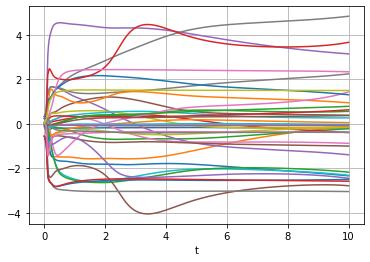

In [278]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.ylim(0,10)
plt.show()

In [279]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(LL+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [280]:
def var_ansatz(theta,psi_0):
    psi = psi_0
    for i in range(coeff*N):
        psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

    return psi

In [281]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [282]:
psi = var_ansatz(start_point,psi_0)

In [283]:
psi_ground = eigenvec[:,0]


In [284]:
expt_value_u = np.zeros(len(time_domain))
energy = np.zeros(len(time_domain))
psi = var_ansatz(start_point,psi_0)
for tt in range(len(time_domain)):
    theta = []
    for i in range(coeff*N):
        theta.append(Y[tt][i])

    psi_var = var_ansatz(theta,psi_0)
    
    for i in range(LL+1):
        psi_var = (Proj[i]+Proj_0[i])@psi_var
    norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

    expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
    energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)


(0.92, 0.96)

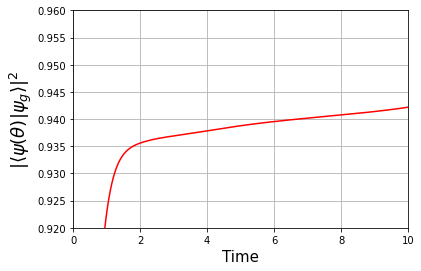

In [289]:
plt.plot(time_domain,expt_value_u, color = "red")
plt.plot(time_domain,1.*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.xlim(0,10)
#plt.ylim(0.92,0.96)

#plt.savefig("Imaginary_time_evolution_fidelity_2d_1plaquette_M=0.1_N=3.pdf",bbox_inches = "tight")

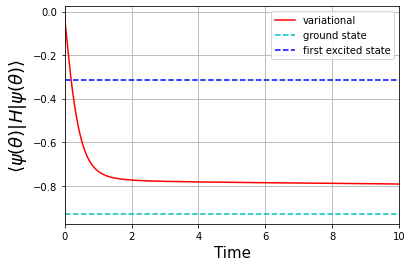

In [286]:
plt.plot(time_domain,energy, color = "red",label = "variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c", label = "ground state")
plt.plot(time_domain,eigenval[1]*np.ones(len(time_domain)), ls = "--", color ="b", label = "first excited state")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.xlim(0,10)
plt.legend()
#plt.ylim(0.9,0.95)

#plt.savefig("Imaginary_time_evolution_energy_2d_1plaquette_M=0.1_N=3.pdf",bbox_inches = "tight")

In [287]:
print(expt_value_u[-1])

0.9421862474845836


In [ ]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
